In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utility import loadData
import math

### Load widefield data U,V,T


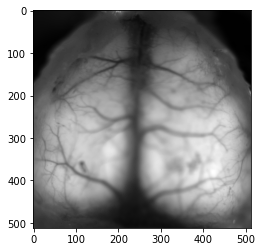

In [2]:
# expRoot = r"\\steinmetzsuper1.biostr.washington.edu\data\Subjects\ZYE_0060\2022-03-24\1"
expRoot = r"\\steinmetzsuper1.biostr.washington.edu\data\Subjects\ZYE_0012\2020-10-16\5"
(U,V,T,mimg) = loadData.loadUVt(expRoot)

plt.figure()
plt.imshow(mimg,cmap='gray') 
plt.show()  # display it

### Load ephys data structure
spikeStruct1 = {st, spikeTemplates, clu, tempScalingAmps, cgs, cids, xcoords, ycoords, temps}

In [9]:
ksDir = r"\\steinmetzsuper1.biostr.washington.edu\data\Subjects\ZYE_0060\2022-03-24\1\p0_g0\p0_g0_imec0"
spikeStruct1 = loadData.loadEphys(ksDir)
spikeStruct1

### select frames, filter and hilbert transform

In [3]:
t_start = 1860
t_end = 1870
f_start = next((indx for indx,x in enumerate(T) if x > t_start), None)
f_end = next((indx for indx,x in enumerate(T) if x > t_end), None)
print(f_start, f_end)
U1 = U[:,:,:50]
V1 = V[f_start:f_end,:50].T
T1 = T[f_start:f_end]
dV1 =np.hstack((np.zeros_like(V1[:,0]).reshape(-1,1), np.diff(V1,axis=1)))
(filtered,amplitude_envelope,instantaneous_phase) = loadData.filter_and_hilbert(U1, dV1)

65008 65358


### plot filtered data, envelope and phase angle

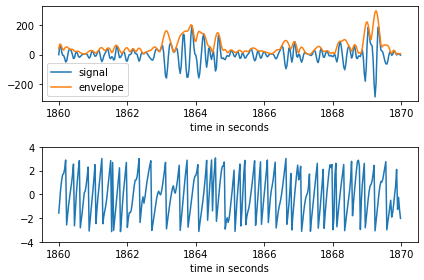

In [4]:
fig, (ax0,ax1) = plt.subplots(nrows=2)
ax0.plot(T1, filtered[400,400,:], label='signal')
ax0.plot(T1, amplitude_envelope[400,400,:], label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1.plot(T1, instantaneous_phase[400,400,:],label='phase')
ax1.set_xlabel("time in seconds")
ax1.set_ylim(-4,4)
fig.tight_layout()

### plot example frame phasemap

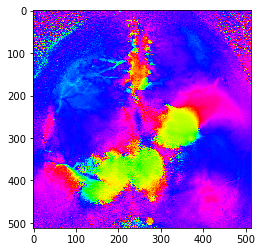

In [5]:
plt.figure()
plt.imshow(instantaneous_phase[:,:,199],cmap='hsv', interpolation= 'None',clim=[-np.pi,np.pi]) 
plt.show()  # display it

### pad zeros around phasemap

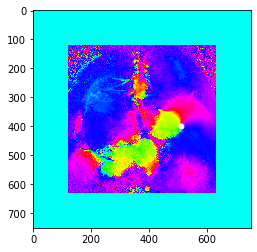

In [4]:
trace_phase = loadData.pad_zeros(instantaneous_phase, halfpadding =120)
plt.figure()
plt.imshow(trace_phase[:,:,199],cmap='hsv', interpolation= 'None',clim=[-np.pi,np.pi]) 
plt.scatter(510,400,s=24, c='w',marker = "o")
plt.show()  # display it

In [5]:
th = np.arange(0,360,36)
r = 20
px = 510
py = 400
cx = np.round(r*np.cos(np.radians(th))+px).astype('int64')
cy = np.round(r*np.sin(np.radians(th))+py).astype('int64')


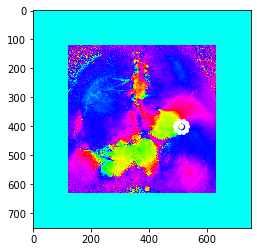

In [6]:
trace_phase = loadData.pad_zeros(instantaneous_phase, halfpadding =120)
plt.figure()
plt.imshow(trace_phase[:,:,199],cmap='hsv', interpolation= 'None',clim=[-np.pi,np.pi]) 
plt.scatter(510,400,s=16, c='w',marker = "o")
plt.scatter(cx,cy,s=16, c='w',marker = "o")
plt.show()  # display it

In [7]:
trace_phase1 = trace_phase[:,:,199]
ph = trace_phase1[cy,cx]

In [8]:
ph2 = np.diff(ph)
ph2

array([-0.08800273, -0.46576476, -0.80074909, -1.42446261, -0.26126228,
       -0.18032975, -0.26720228,  4.92371997, -1.00188739])

In [9]:
ph3 = (ph2 + np.pi) % (2 * np.pi) - np.pi
ph3.shape

(9,)

In [10]:
ph4 = np.zeros((ph3.shape[0],1))
ph4[0] = ph3[0]
for i in np.arange(1,ph3.shape[0]):   
    print(i)
    ph4[i] = ph4[i-1]+ph3[i]
ph4

1
2
3
4
5
6
7
8


array([[-0.08800273],
       [-0.5537675 ],
       [-1.35451659],
       [-2.77897921],
       [-3.04024149],
       [-3.22057124],
       [-3.48777352],
       [-4.84723885],
       [-5.84912624]])

In [11]:
spiral_range = np.linspace(-np.pi,np.pi,5)
angle_range = abs(ph4[-1]-ph4[0])               
hist_n, bin_edges = np.histogram(ph, bins=spiral_range)

In [12]:
spiral_temp = [px,py,r,0]
if np.all(angle_range>5) & np.all(angle_range<7) & all(hist_n):
    spiral_temp[-1] = 1
    

In [13]:
spiral_temp

[510, 400, 20, 1]

In [14]:
def wrapToPi(lambda1):
    lambda1 = (lambda1 + np.pi) % (2 * np.pi) - np.pi
    return lambda1

In [15]:
def check_spiral(trace_phase,px,py,r,th,spiral_range):
#     th = np.arange(0,360,36)
#     r = 20
#     px = 510
#     py = 400
#     spiral_range = np.linspace(-np.pi,np.pi,5)
    cx = np.round(r*np.cos(np.radians(th))+px).astype('int64')
    cy = np.round(r*np.sin(np.radians(th))+py).astype('int64')
    trace_phase = loadData.pad_zeros(instantaneous_phase, halfpadding =120)
    trace_phase1 = trace_phase[:,:,199]
    ph = trace_phase1[cy,cx]
    ph2 = np.diff(ph)
    ph3 = wrapToPi(ph2)
    ph4 = np.zeros((ph3.shape[0],1))
    ph4[0] = ph3[0]
    for i in np.arange(1,ph3.shape[0]):   
        ph4[i] = ph4[i-1]+ph3[i]    
    angle_range = abs(ph4[-1]-ph4[0])               
    hist_n, bin_edges = np.histogram(ph, bins=spiral_range)
    spiral_temp = [px,py,r,0]
    if np.all(angle_range>5) & np.all(angle_range<7) & all(hist_n):
        spiral_temp[-1] = 1
    return spiral_temp

In [16]:
th = np.arange(0,360,36)
r = 20
px = 510
py = 400
spiral_temp = check_spiral(trace_phase,px,py,r,th,spiral_range)

In [17]:
spiral_temp

[510, 400, 20, 1]